# WRAPPED CLASSIFIER WITH NAIVE TEACHER

>>>> Oleg I.Berngardt,

>>>> ISTP SB RAS, 

>>>> Irkutsk State University

>>>> Irkutsk, Russia, June, 2022

#Initial dataset and problem formulation

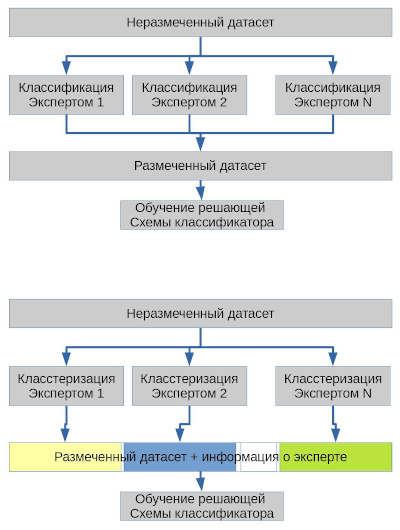

## Generate artificial dataset

- 8 coordiantes
- 10 classes
- 100000 examples

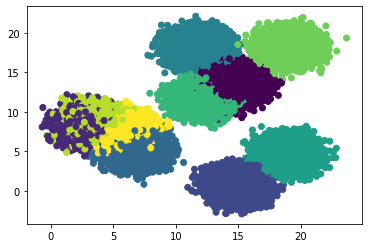

In [ ]:
from sklearn.datasets import make_blobs
N_FEATURES=8
N_CLASSES=10
X,Y=make_blobs(n_samples=100000, 
                      n_features=N_FEATURES, 
                      centers=np.random.uniform(0,20,size=(N_CLASSES,N_FEATURES)), 
                      random_state=42)
TOTAL_SAMPLES=X.shape[0]
import matplotlib.pyplot as pp
pp.scatter(X[:,0],X[:,2],c=Y);

## Separate the dataset into experiments 


(100000, 1)
idx exp shape: (100000, 1)


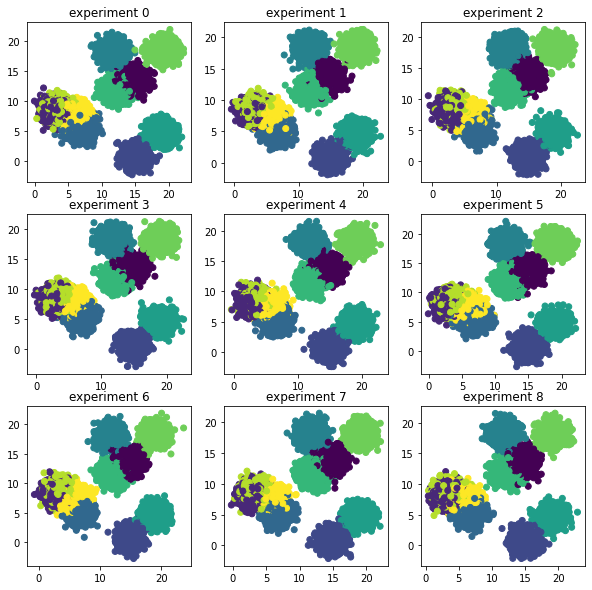

In [ ]:
import numpy as np
MAX_EXPERIMENTS=9
max_experiments=MAX_EXPERIMENTS
np.random.seed(42)
idxs=np.random.randint(0,max_experiments,(X.shape[0],1))
print(idxs.shape)
x_exp,y_exp,idx_exp=[],[],[]
for i in range(max_experiments):
  x_exp.append(X[idxs[:,0]==i])
  y_exp.append(Y[idxs[:,0]==i])
  if i==0:
    idx_exp=idxs[idxs[:,0]==i].copy()
  else:
    idx_exp=np.concatenate((idx_exp,idxs[idxs[:,0]==i]),axis=0)

print('idx exp shape:',idx_exp.shape)
fig,axs=pp.subplots(max_experiments//3,3,figsize=(10,10))
for i in range(max_experiments):
  axs[i//3,i%3].set_title('experiment '+str(i))
  axs[i//3,i%3].scatter(x_exp[i][:,0],x_exp[i][:,2],c=y_exp[i])

## Сlusterize each experiment separately

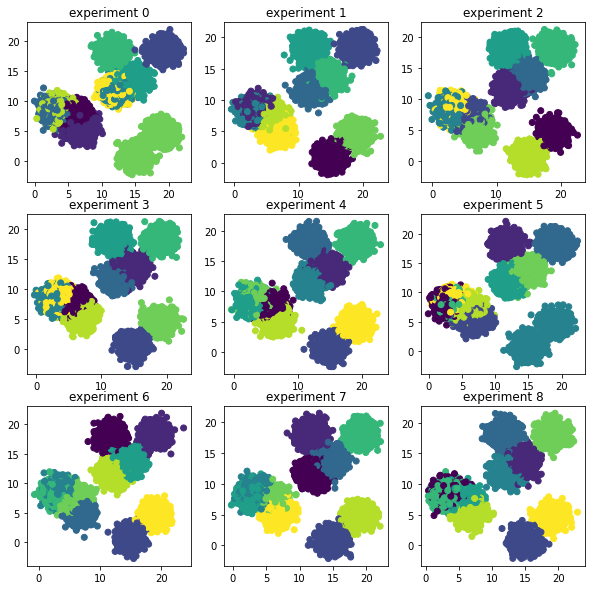

In [ ]:
from sklearn.mixture import GaussianMixture
gm=GaussianMixture(n_components=N_CLASSES)
cl=[]
XOUT=[]
for i in range(max_experiments):
  cl.append(gm.fit_predict(x_exp[i]))

fig,axs=pp.subplots(max_experiments//3,3,figsize=(10,10))
for i in range(max_experiments):
  axs[i//3,i%3].set_title('experiment '+str(i))
  axs[i//3,i%3].scatter(x_exp[i][:,0],x_exp[i][:,2],c=cl[i])

## Проблема: у каждого эксперта(эксперимента) цвет одной и той-же точки может быть разным

Вопросы: 
- Можно-ли по результатам такой кластеризации сделать решающую схему (классификатор) так, чтобы одинаковые точки в каждом эксперименте имели одинаковые цвета? 
- Можно-ли использовать результаты такой кластеризации для обучения классификатора?

# SOLUTION: wrapped classifier with naive teacher

## IDEA

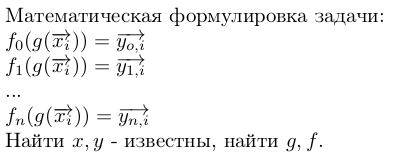

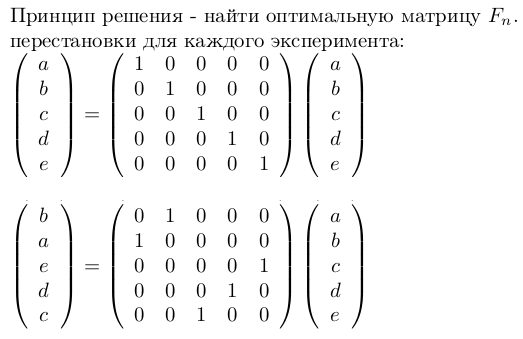

## IMPLEMENTATION

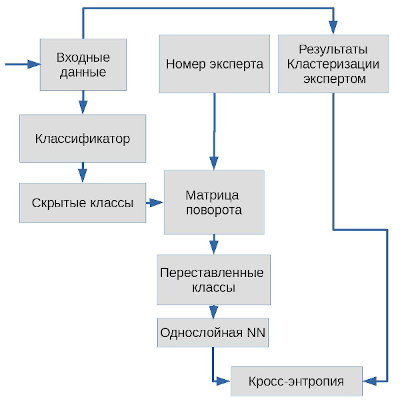

### Import libraries and  fill dataset

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random

#def mjoin(a,b,c):
# return np.concatenate((np.array(a),np.array(b),np.array(c)))

In [ ]:

for i in range(max_experiments):
  p=np.array([[x] for x in cl[i]])
  print('experiment shape:',p.shape)
  if i==0:
    clusters=p
    XOUT=np.array(x_exp[i])[:,:N_FEATURES]
  else:
    clusters=np.concatenate((clusters,p))
    XOUT=np.concatenate((XOUT,np.array(x_exp[i])[:,:N_FEATURES]))
idx_exp=np.array(idx_exp)
print('idx_exp:',idx_exp.shape)
print('clusters shape:',clusters.shape)
input_data=np.concatenate((XOUT,idx_exp,clusters),axis=1)
print('data shape:',input_data.shape)

experiment shape: (11064, 1)
experiment shape: (11043, 1)
experiment shape: (10991, 1)
experiment shape: (11135, 1)
experiment shape: (11146, 1)
experiment shape: (11166, 1)
experiment shape: (11236, 1)
experiment shape: (11083, 1)
experiment shape: (11136, 1)
idx_exp: (100000, 1)
clusters shape: (100000, 1)
data shape: (100000, 10)


In [ ]:
vecInputNum=N_FEATURES
MaxDates=max_experiments

output_class_M=clusters[:,0].max()+1
max_days=idxs[:,0].max()+1

ASYMMETRY=dict()
for i in range(output_class_M):
  ASYMMETRY[i]=clusters[clusters[:,0]==i].shape[0]
print('Asymmetry:',ASYMMETRY)

Asymmetry: {0: 9809, 1: 10079, 2: 10075, 3: 9910, 4: 10596, 5: 10065, 6: 9480, 7: 11048, 8: 10003, 9: 8935}


In [ ]:
print('input data shape',input_data.shape)
XARR1=input_data[:,:N_FEATURES+1]
print('Input data for network:',XARR1.shape)
YARR1=tf.keras.utils.to_categorical(input_data[:,N_FEATURES+1],num_classes=output_class_M)
print('Categorical cluster nums:',YARR1.shape)

input data shape (100000, 10)
Input data for network: (100000, 9)
Categorical cluster nums: (100000, 10)


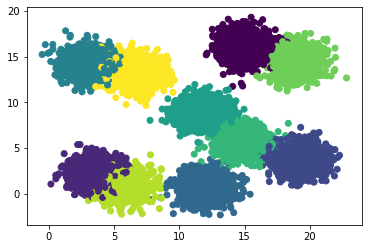

In [ ]:
pp.scatter(XARR1[XARR1[:,N_FEATURES]==1,0],XARR1[XARR1[:,N_FEATURES]==1,1],c=input_data[XARR1[:,N_FEATURES]==1,N_FEATURES+1])

In [ ]:
vecInputNumPoly=vecInputNum
hidden_dim=vecInputNumPoly+output_class_M+2  #universal approximation theorem
if hidden_dim < vecInputNumPoly*2+1:
 hidden_dim = vecInputNumPoly*2+1  #Kolmogorov theorem
print('yarr shape',np.array(YARR1).shape);
print('xarr shape',np.array(XARR1).shape);
# num=i-1


yarr shape (100000, 10)
xarr shape (100000, 9)


### Separate dataset into train and test datasets

In [ ]:
from sklearn.model_selection import train_test_split
XARRtrain,XARRval,YARRtrain,YARRval=train_test_split(XARR1,YARR1,test_size=0.2)

XARRtrain=np.array(XARRtrain)
YARRtrain=np.array(YARRtrain)
XARRval=np.array(XARRval)
YARRval=np.array(YARRval)

print('Xt:',XARRtrain.shape)
print('Yt:',YARRtrain.shape)
print('Xtst:',XARRval.shape)
print('Ytst:',YARRval.shape)
print("X train shape:",XARRtrain.shape)
print("Y train shape:",YARRtrain.shape)

Xt: (80000, 9)
Yt: (80000, 10)
Xtst: (20000, 9)
Ytst: (20000, 10)
X train shape: (80000, 9)
Y train shape: (80000, 10)
final calc weights


### Calculate weights

In [ ]:
gam=1
class_weight_dict=dict()
for i in range(output_class_M):
  class_weight_dict[i]=0
sum_p=0
for key, value in ASYMMETRY.items() :
  p=ASYMMETRY[key]
  sum_p+=p
total_nonzero_classes=0
SMALLEST_CLASS=1e-3
#REG_LAMBDA=SMALLEST_CLASS*0.1
REG_LAMBDA=SMALLEST_CLASS

for key, value in ASYMMETRY.items() :
  p=(ASYMMETRY[key])/sum_p
#  if(classes_sel[key] in class_weight_dict):
  class_weight_dict[key]=0  
  if(p>SMALLEST_CLASS):
    class_weight_dict[key]=1/p**gam  
    total_nonzero_classes+=1

totalClassNum=output_class_M*2 #total_nonzero_classes

print("final weights",class_weight_dict)
print("total hidden classes",totalClassNum)
#quit()

final weights {0: 10.194719135487817, 1: 9.921619208254787, 2: 9.925558312655086, 3: 10.090817356205854, 4: 9.437523593808985, 5: 9.935419771485344, 6: 10.548523206751055, 7: 9.051412020275164, 8: 9.997000899730082, 9: 11.19194180190263}
total hidden classes 20


## Build network

### Build Classifier network

In [ ]:
vecInputNum2=vecInputNumPoly

print ("configure model short with ",vecInputNum2," paramters")
vectorInput = keras.Input(shape=(vecInputNum2,), name="vec_input")  
vec_features= vectorInput

basic_act='selu'
lang_act='softmax'
for layer in range(2):
  vec_features = layers.Dense(hidden_dim, name="transform1_"+str(layer), activation=basic_act)(vec_features)
  vec_features = layers.Dense(hidden_dim, name="transform2_"+str(layer), activation=basic_act)(vec_features)
  vec_features = layers.Dense(hidden_dim, name="transform3_"+str(layer), activation=basic_act)(vec_features)
  vec_features=tf.keras.layers.BatchNormalization()(vec_features)
  vec_features = layers.Dropout(0.3)(vec_features)


secondaryClasses = layers.Dense(totalClassNum, 
				name="secondaryClasses", 
				activation=lang_act,
				)(vec_features)

base_model = keras.Model(
    inputs=[vectorInput],
    outputs=[secondaryClasses],
    trainable=True
)

base_model.summary()

configure model short with  8  paramters
Model: "model_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vec_input (InputLayer)      [(None, 8)]               0         
                                                                 
 transform1_0 (Dense)        (None, 20)                180       
                                                                 
 transform2_0 (Dense)        (None, 20)                420       
                                                                 
 transform3_0 (Dense)        (None, 20)                420       
                                                                 
 batch_normalization_61 (Bat  (None, 20)               80        
 chNormalization)                                                
                                                                 
 dropout_61 (Dropout)        (None, 20)                0         
                 

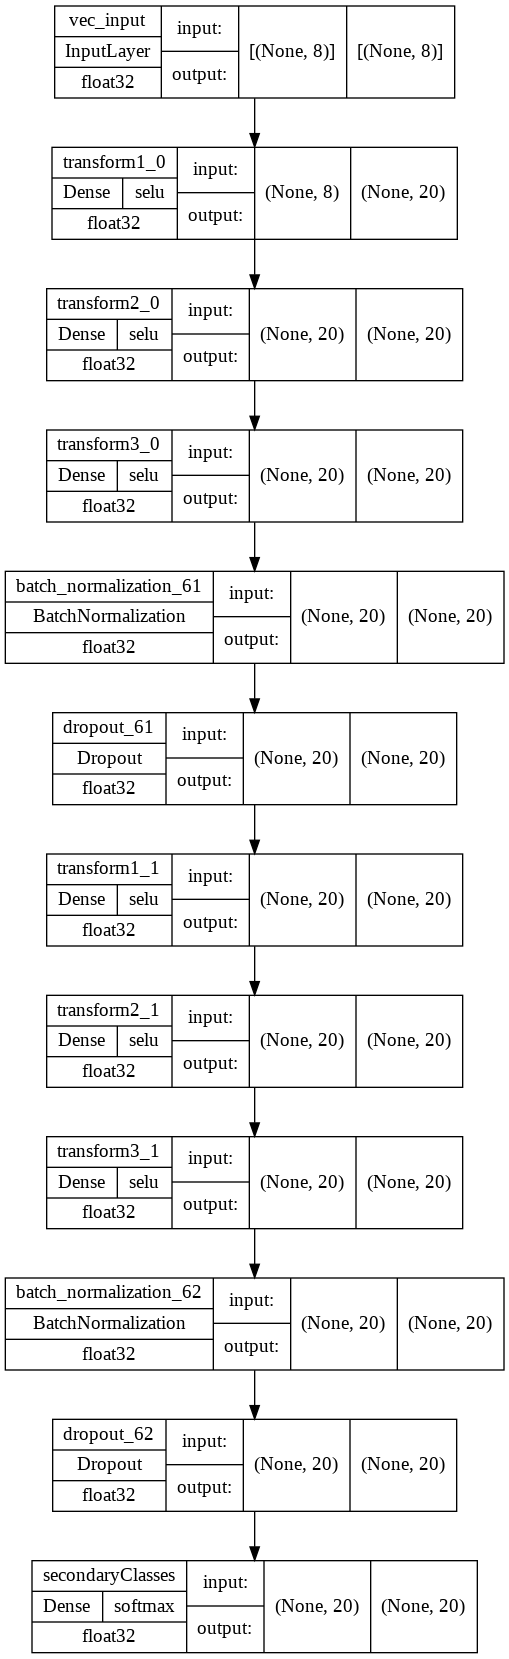

In [ ]:
keras.utils.plot_model(base_model, 'model.classifier.png', show_shapes=True,show_layer_activations=True, show_layer_names=True,show_dtype=True)

### Build Wrap network

In [ ]:
print ("configure model")
totalInput = keras.Input(shape=(vecInputNumPoly+1,), name="vec_date")  

#split input into experiment numer and classifier input
vec_input,date_input2=tf.split(totalInput, [vecInputNum2,1], 1)

# pass through Classifier model
secondaryClassesOut=base_model(vec_input)

#build rectangle embedding for each experiment
date_input=date_input2
sec_input_features=secondaryClassesOut
MaxExperiments=max_experiments
#from tensorflow.keras.constraints import NonNeg

from tensorflow.keras.constraints import NonNeg,non_neg

embedding_layer=layers.Embedding(MaxExperiments,totalClassNum*output_class_M,name="ExperimentEmb",
		    # embeddings_constraint=NonNeg,
        # embeddings_initializer='ones',
		    )
print('DI shape',date_input.shape)
conversion_weights=embedding_layer(date_input)
print('CW',conversion_weights.shape)

#transform embedding row into rectangle matrix
conversion_matrix_T=layers.Reshape((output_class_M,totalClassNum))(conversion_weights)
#make sure that matrix is non-negative valued
conversion_matrix_T=layers.ReLU(name="getOnlyPositiveValues")(conversion_matrix_T)

print('CM shape',conversion_matrix_T.shape)
print('SIF shape',sec_input_features.shape)

#transform classes of classifier into classes of GaussianMixture for each experiment separately
output_features=layers.Dot(axes=(2,1))([conversion_matrix_T,sec_input_features])
print('OF3hape',output_features.shape)

#pass through simple classifer

#actualOutputClasses = layers.Softmax()(output_features)


actualOutputClasses = layers.Dense(output_class_M, 
                                   name="actualOutputClasses", 
                                   activation='softmax',
                                   kernel_constraint=non_neg(),
        )(output_features)

model = keras.Model(
    inputs=[totalInput],
    outputs=[actualOutputClasses],
)
model.summary()

configure model
DI shape (None, 1)
CW (None, 1, 200)
CM shape (None, 10, 20)
SIF shape (None, 20)
OF3hape (None, 10)
Model: "model_54"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vec_date (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 tf.split_28 (TFOpLambda)       [(None, 8),          0           ['vec_date[0][0]']               
                                 (None, 1)]                                                       
                                                                                                  
 ExperimentEmb (Embedding)      (None, 1, 200)       1800        ['tf.split_28[0][1]']            
                                                                         

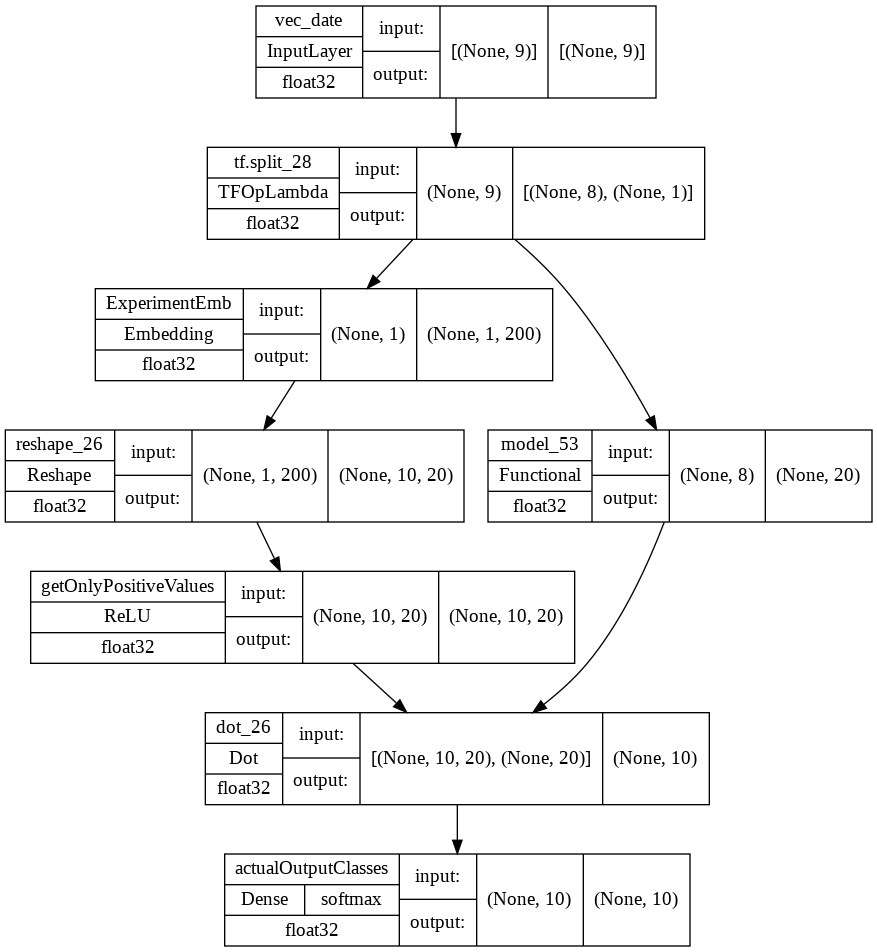

In [ ]:
keras.utils.plot_model(model, 'model.wrap.png', show_shapes=True,show_layer_activations=True, show_layer_names=True,show_dtype=True)

### Compile and plot models

In [ ]:
print ("compile model")
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.AUC(curve='PR'),
                       tf.keras.metrics.AUC(curve='ROC')
                      ]
              )


compile model


### Fit models

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc_47', mode='max', patience=5)
print ("fit model...")
model.fit(x=XARRtrain,y=YARRtrain,batch_size=32,
          epochs=1500,verbose=1,validation_split=0.2,
          class_weight = class_weight_dict, 
          callbacks=[callback])
print ("save model")

tf.keras.models.save_model(model, 'model.wrap.ec')
tf.keras.models.save_model(base_model, 'model.classifier.ec')
# !tar -cvzf dbscan-model-Full-p_le_e-4-vars_15-sm-100epoches.tgz ./dbscan


fit model...
Epoch 1/1500
2000/2000 [==============================] - 9s 3ms/step - loss: 17.7522 - auc_47: 0.4925 - auc_48: 0.8513 - val_loss: 1.3187 - val_auc_47: 0.6549 - val_auc_48: 0.9148
Epoch 2/1500
2000/2000 [==============================] - 7s 3ms/step - loss: 11.9426 - auc_47: 0.6677 - auc_48: 0.9253 - val_loss: 1.1182 - val_auc_47: 0.6887 - val_auc_48: 0.9329
Epoch 3/1500
2000/2000 [==============================] - 6s 3ms/step - loss: 10.7573 - auc_47: 0.6957 - auc_48: 0.9375 - val_loss: 1.0437 - val_auc_47: 0.7052 - val_auc_48: 0.9407
Epoch 4/1500
2000/2000 [==============================] - 7s 3ms/step - loss: 9.3799 - auc_47: 0.7476 - auc_48: 0.9555 - val_loss: 0.8458 - val_auc_47: 0.7861 - val_auc_48: 0.9649
Epoch 5/1500
2000/2000 [==============================] - 9s 4ms/step - loss: 8.1950 - auc_47: 0.7887 - auc_48: 0.9651 - val_loss: 0.7712 - val_auc_47: 0.8130 - val_auc_48: 0.9694
Epoch 6/1500
2000/2000 [==============================] - 7s 3ms/step - loss: 7.5842

### Estimate fit quality at train dataset

In [ ]:
print ("get error matrix")
y_pred=model.predict(XARRtrain)
yp=tf.math.argmax(y_pred,axis=1)
yt=tf.math.argmax(YARRtrain,axis=1)
con_mat = tf.math.confusion_matrix(labels=yt,predictions=yp).numpy()
con_mat_norm = np.around(con_mat.astype('float') / (con_mat.sum(axis=1)[:, np.newaxis]+1), decimals=2)
np.set_printoptions(precision=4)
print('train set diag',np.diag(con_mat_norm))

get error matrix
train set diag [1.   1.   1.   1.   0.95 1.   1.   1.   1.   0.94]


### Estimate fit quality at test dataset

In [ ]:


y_pred=model.predict(XARRval)
yp=tf.math.argmax(y_pred,axis=1)
yt=tf.math.argmax(YARRval,axis=1)
con_mat = tf.math.confusion_matrix(labels=yt,predictions=yp).numpy()
con_mat_norm = np.around(con_mat.astype('float') / (con_mat.sum(axis=1)[:, np.newaxis]+1), decimals=2)
print('val  set diag',np.diag(con_mat_norm))

print ("error matrix:")

print(con_mat_norm)

val  set diag [1.   1.   1.   1.   0.95 1.   1.   1.   1.   0.93]
error matrix:
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.95 0.   0.   0.   0.   0.05]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.07 0.   0.   0.93]]


## Illustration of classifier

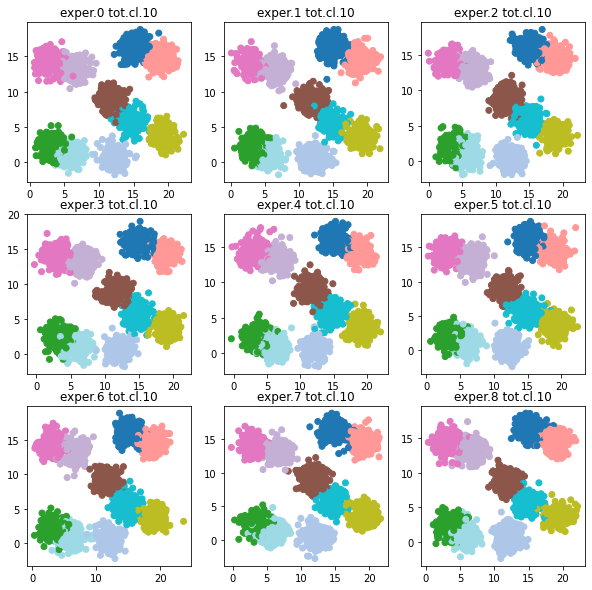

In [ ]:
fig,axs=pp.subplots(max_experiments//3,3,figsize=(10,10))
for i in range(max_experiments):
  x=XARRval[XARRval[:,N_FEATURES]==i]
  y=np.argmax(base_model.predict(x[:,:N_FEATURES]),axis=1)
  yt=np.argmax(YARRval[XARRval[:,N_FEATURES]==i],axis=1)
  axs[i//3,i%3].scatter(x[:,0],x[:,1],c=y,cmap='tab20');
  axs[i//3,i%3].set_title('exper.'+str(i)+' tot.cl.'+str(len(set(list(y)))))

### Сравнение внешних классов и внтуренних для эксперимента №9 

In [ ]:

con_mat = tf.math.confusion_matrix(labels=yt,predictions=y).numpy()
print(con_mat)

[[  0   0   0   0 219   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 206   0]
 [252   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 246   0   0   0   0   0   0   0   0]
 [  0 246   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 220]
 [  0   0   0   0   0   0   0   0   0   0   0 240   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 205   0   0   0]
 [  0   0   0   0   0   0   0   0 214   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 201   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0

# In case of mistakes of clusterer - smaller number of detected clusters

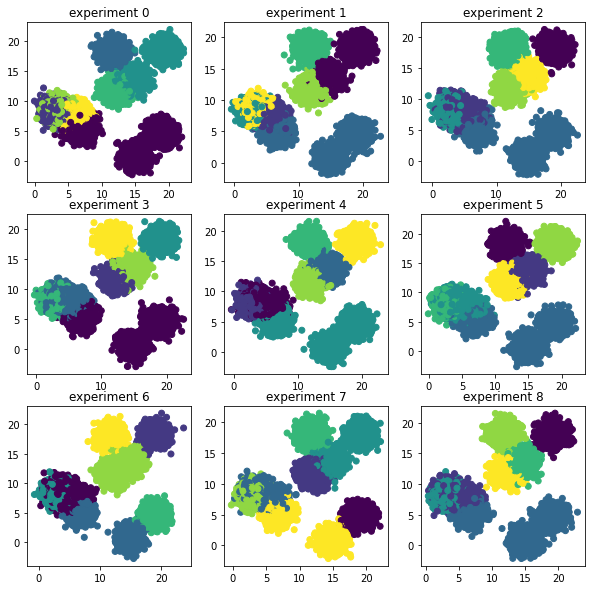

In [ ]:
from sklearn.mixture import GaussianMixture
gm=GaussianMixture(n_components=N_CLASSES*7//10)
cl=[]
XOUT=[]
for i in range(max_experiments):
  cl.append(gm.fit_predict(x_exp[i]))

fig,axs=pp.subplots(max_experiments//3,3,figsize=(10,10))
for i in range(max_experiments):
  axs[i//3,i%3].set_title('experiment '+str(i))
  axs[i//3,i%3].scatter(x_exp[i][:,0],x_exp[i][:,2],c=cl[i])

## Lots of code

### Configure network

In [ ]:
for i in range(max_experiments):
  p=np.array([[x] for x in cl[i]])
  print('experiment shape:',p.shape)
  if i==0:
    clusters=p
    XOUT=np.array(x_exp[i])[:,:N_FEATURES]
  else:
    clusters=np.concatenate((clusters,p))
    XOUT=np.concatenate((XOUT,np.array(x_exp[i])[:,:N_FEATURES]))
idx_exp=np.array(idx_exp)
print('idx_exp:',idx_exp.shape)
print('clusters shape:',clusters.shape)
input_data=np.concatenate((XOUT,idx_exp,clusters),axis=1)
print('data shape:',input_data.shape)

experiment shape: (11064, 1)
experiment shape: (11043, 1)
experiment shape: (10991, 1)
experiment shape: (11135, 1)
experiment shape: (11146, 1)
experiment shape: (11166, 1)
experiment shape: (11236, 1)
experiment shape: (11083, 1)
experiment shape: (11136, 1)
idx_exp: (100000, 1)
clusters shape: (100000, 1)
data shape: (100000, 10)


In [ ]:
vecInputNum=N_FEATURES
MaxDates=max_experiments

output_class_M=clusters[:,0].max()+1
max_days=idxs[:,0].max()+1

ASYMMETRY=dict()
for i in range(output_class_M):
  ASYMMETRY[i]=clusters[clusters[:,0]==i].shape[0]
print('Asymmetry:',ASYMMETRY)

Asymmetry: {0: 17847, 1: 12198, 2: 22158, 3: 15636, 4: 9922, 5: 11139, 6: 11100}


In [ ]:
print('input data shape',input_data.shape)
XARR1=input_data[:,:N_FEATURES+1]
print('Input data for network:',XARR1.shape)
YARR1=tf.keras.utils.to_categorical(input_data[:,N_FEATURES+1],num_classes=output_class_M)
print('Categorical cluster nums:',YARR1.shape)

input data shape (100000, 10)
Input data for network: (100000, 9)
Categorical cluster nums: (100000, 7)


In [ ]:
vecInputNumPoly=vecInputNum
hidden_dim=vecInputNumPoly+output_class_M+2  #universal approximation theorem
if hidden_dim < vecInputNumPoly*2+1:
 hidden_dim = vecInputNumPoly*2+1  #Kolmogorov theorem
print('yarr shape',np.array(YARR1).shape);
print('xarr shape',np.array(XARR1).shape);

yarr shape (100000, 7)
xarr shape (100000, 9)


### Separate dataset into train and test datasets

In [ ]:
from sklearn.model_selection import train_test_split
XARRtrain,XARRval,YARRtrain,YARRval=train_test_split(XARR1,YARR1,test_size=0.2)

XARRtrain=np.array(XARRtrain)
YARRtrain=np.array(YARRtrain)
XARRval=np.array(XARRval)
YARRval=np.array(YARRval)

print('Xt:',XARRtrain.shape)
print('Yt:',YARRtrain.shape)
print('Xtst:',XARRval.shape)
print('Ytst:',YARRval.shape)


# print(XARRtrain)

#XARRval=np.array(random.sample(XARR1,int(num*0.1)))
#YARRval=np.array(YARR1[int(num*0.5):])


#YARRval=np.array(random.sample(YARR1,int(num*0.1)))

#f.close()
# print(XARR1[0],YARR1[0])
print("X train shape:",XARRtrain.shape)
print("Y train shape:",YARRtrain.shape)

# from sklearn.utils import class_weight
# print(np.unique(np.array(Cl_Y)))
# class_weight = class_weight.compute_class_weight('balanced',np.unique(np.array(Cl_Y)),Cl_Y)
# print("sklearn class weights ",class_weight)

print ("final calc weights")

# print(class_weight)
# min_cw=class_weight.min()
# sum_cw=class_weight.sum()

Xt: (80000, 9)
Yt: (80000, 7)
Xtst: (20000, 9)
Ytst: (20000, 7)
X train shape: (80000, 9)
Y train shape: (80000, 7)
final calc weights


### Calculate weights

In [ ]:
gam=1
class_weight_dict=dict()
for i in range(output_class_M):
  class_weight_dict[i]=0
sum_p=0
for key, value in ASYMMETRY.items() :
  p=ASYMMETRY[key]
  sum_p+=p
total_nonzero_classes=0
SMALLEST_CLASS=1e-3
#REG_LAMBDA=SMALLEST_CLASS*0.1
REG_LAMBDA=SMALLEST_CLASS

for key, value in ASYMMETRY.items() :
  p=(ASYMMETRY[key])/sum_p
#  if(classes_sel[key] in class_weight_dict):
  class_weight_dict[key]=0  
  if(p>SMALLEST_CLASS):
    class_weight_dict[key]=1/p**gam  
    total_nonzero_classes+=1

totalClassNum=output_class_M*2 #total_nonzero_classes

print("final weights",class_weight_dict)
print("total hidden classes",totalClassNum)
#quit()

final weights {0: 5.603182607721186, 1: 8.198065256599442, 2: 4.51304269338388, 3: 6.3954975697109235, 4: 10.078613182826043, 5: 8.977466558937067, 6: 9.00900900900901}
total hidden classes 14


### Build network

### Build Classifier network

In [ ]:
vecInputNum2=vecInputNumPoly

print ("configure model short with ",vecInputNum2," paramters")
vectorInput = keras.Input(shape=(vecInputNum2,), name="vec_input")  
vec_features= vectorInput

basic_act='selu'
lang_act='softmax'
for layer in range(2):
  vec_features = layers.Dense(hidden_dim, name="transform1_"+str(layer), activation=basic_act)(vec_features)
  vec_features = layers.Dense(hidden_dim, name="transform2_"+str(layer), activation=basic_act)(vec_features)
  vec_features = layers.Dense(hidden_dim, name="transform3_"+str(layer), activation=basic_act)(vec_features)
  vec_features=tf.keras.layers.BatchNormalization()(vec_features)
  vec_features = layers.Dropout(0.3)(vec_features)


secondaryClasses = layers.Dense(totalClassNum, 
				name="secondaryClasses", 
				activation=lang_act,
				)(vec_features)

base_model = keras.Model(
    inputs=[vectorInput],
    outputs=[secondaryClasses],
    trainable=True
)

base_model.summary()

configure model short with  8  paramters
Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vec_input (InputLayer)      [(None, 8)]               0         
                                                                 
 transform1_0 (Dense)        (None, 17)                153       
                                                                 
 transform2_0 (Dense)        (None, 17)                306       
                                                                 
 transform3_0 (Dense)        (None, 17)                306       
                                                                 
 batch_normalization_63 (Bat  (None, 17)               68        
 chNormalization)                                                
                                                                 
 dropout_63 (Dropout)        (None, 17)                0         
                 

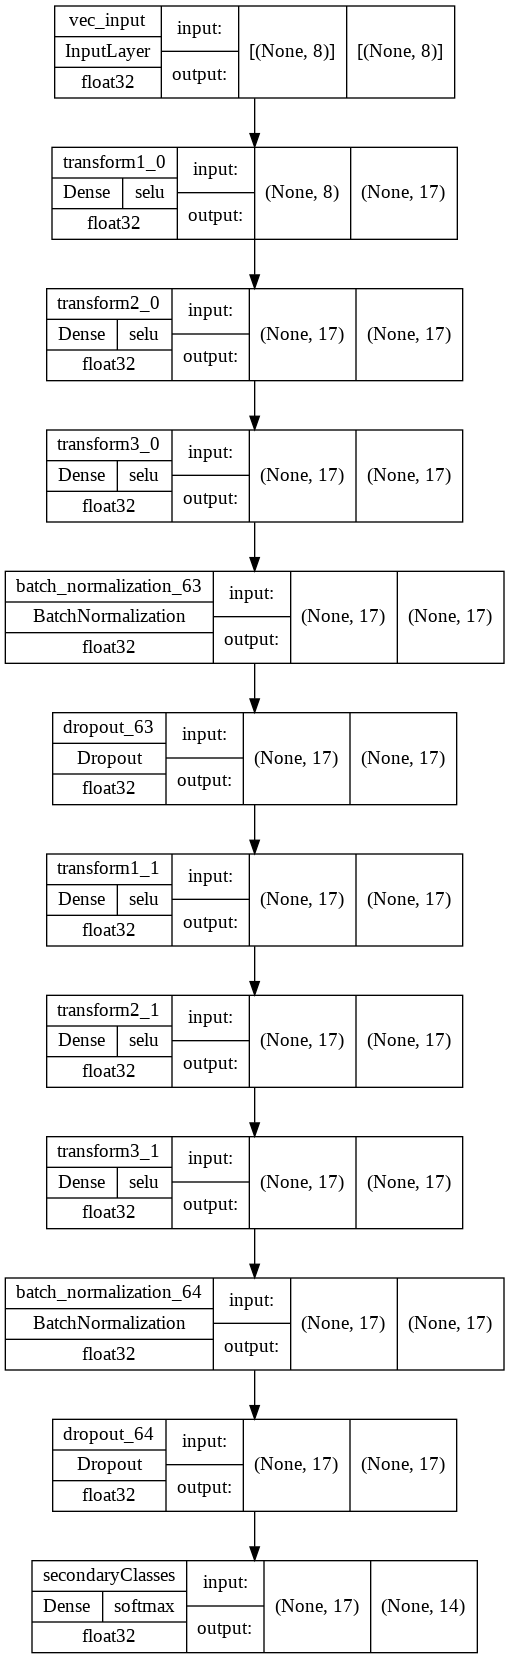

In [ ]:
keras.utils.plot_model(base_model, 'model.classifier.png', show_shapes=True,show_layer_activations=True, show_layer_names=True,show_dtype=True)

### Build Wrap network

In [ ]:
print ("configure model")
totalInput = keras.Input(shape=(vecInputNumPoly+1,), name="vec_date")  

#split input into experiment numer and classifier input
vec_input,date_input2=tf.split(totalInput, [vecInputNum2,1], 1)

# pass through Classifier model
secondaryClassesOut=base_model(vec_input)

#build rectangle embedding for each experiment
date_input=date_input2
sec_input_features=secondaryClassesOut
MaxExperiments=max_experiments
#from tensorflow.keras.constraints import NonNeg

from tensorflow.keras.constraints import NonNeg,non_neg

embedding_layer=layers.Embedding(MaxExperiments,totalClassNum*output_class_M,name="ExperimentEmb",
		    # embeddings_constraint=NonNeg,
        # embeddings_initializer='ones',
		    )
print('DI shape',date_input.shape)
conversion_weights=embedding_layer(date_input)
print('CW',conversion_weights.shape)

#transform embedding row into rectangle matrix
conversion_matrix_T=layers.Reshape((output_class_M,totalClassNum))(conversion_weights)
#make sure that matrix is non-negative valued
conversion_matrix_T=layers.ReLU(name="getOnlyPositiveValues")(conversion_matrix_T)

print('CM shape',conversion_matrix_T.shape)
print('SIF shape',sec_input_features.shape)

#transform classes of classifier into classes of GaussianMixture for each experiment separately
output_features=layers.Dot(axes=(2,1))([conversion_matrix_T,sec_input_features])
print('OF3hape',output_features.shape)

#pass through simple classifer

#actualOutputClasses = layers.Softmax()(output_features)


actualOutputClasses = layers.Dense(output_class_M, 
                                   name="actualOutputClasses", 
                                   activation='softmax',
                                   kernel_constraint=non_neg(),
        )(output_features)

model = keras.Model(
    inputs=[totalInput],
    outputs=[actualOutputClasses],
)
model.summary()

configure model
DI shape (None, 1)
CW (None, 1, 98)
CM shape (None, 7, 14)
SIF shape (None, 14)
OF3hape (None, 7)
Model: "model_56"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vec_date (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 tf.split_29 (TFOpLambda)       [(None, 8),          0           ['vec_date[0][0]']               
                                 (None, 1)]                                                       
                                                                                                  
 ExperimentEmb (Embedding)      (None, 1, 98)        882         ['tf.split_29[0][1]']            
                                                                            

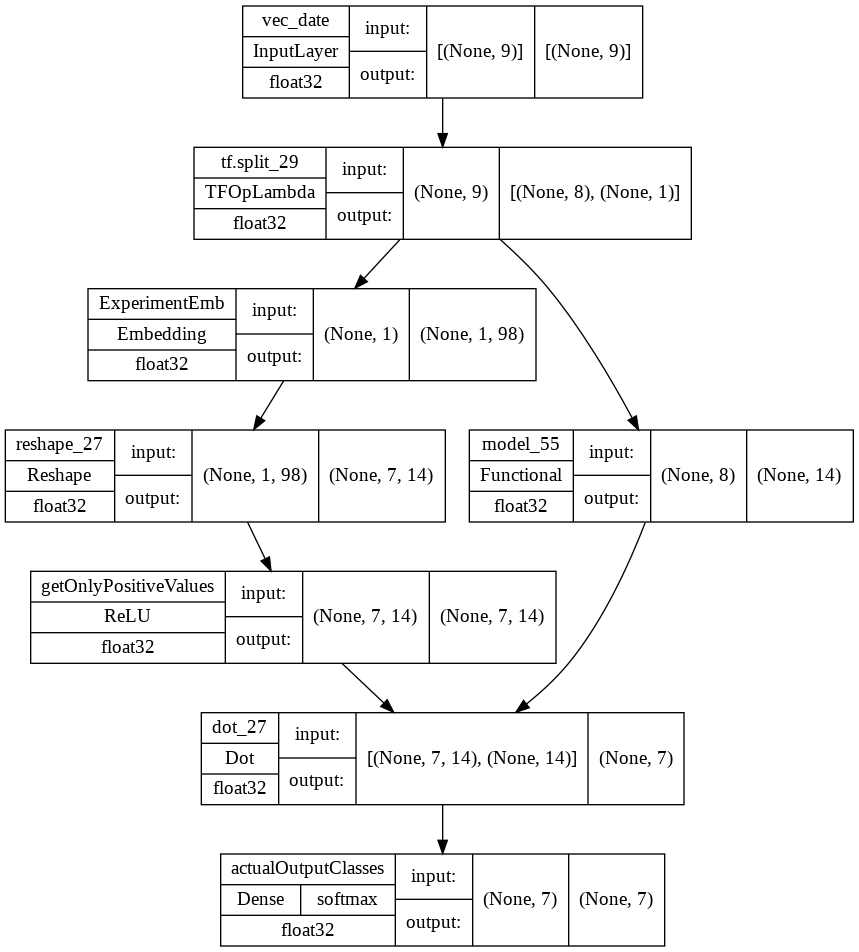

In [ ]:
keras.utils.plot_model(model, 'model.wrap.png', show_shapes=True,show_layer_activations=True, show_layer_names=True,show_dtype=True)

### Compile and plot models

In [ ]:
print ("compile model")
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.AUC(curve='PR'),
                       tf.keras.metrics.AUC(curve='ROC')
                      ]
              )


compile model


### Fit models

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc_49', mode='max', patience=5)
print ("fit model...")
model.fit(x=XARRtrain,y=YARRtrain,batch_size=32,
          epochs=1500,verbose=1,validation_split=0.2,
          class_weight = class_weight_dict, 
          callbacks=[callback])
print ("save model")

tf.keras.models.save_model(model, 'model.wrap.ec')
tf.keras.models.save_model(base_model, 'model.classifier.ec')
# !tar -cvzf dbscan-model-Full-p_le_e-4-vars_15-sm-100epoches.tgz ./dbscan


fit model...
Epoch 1/1500
2000/2000 [==============================] - 14s 7ms/step - loss: 6.6676 - auc_49: 0.7869 - auc_50: 0.9342 - val_loss: 0.8435 - val_auc_49: 0.7958 - val_auc_50: 0.9369
Epoch 2/1500
2000/2000 [==============================] - 8s 4ms/step - loss: 6.2013 - auc_49: 0.8072 - auc_50: 0.9410 - val_loss: 0.8071 - val_auc_49: 0.8083 - val_auc_50: 0.9420
Epoch 3/1500
2000/2000 [==============================] - 7s 4ms/step - loss: 5.9886 - auc_49: 0.8154 - auc_50: 0.9438 - val_loss: 0.7870 - val_auc_49: 0.8152 - val_auc_50: 0.9437
Epoch 4/1500
2000/2000 [==============================] - 7s 3ms/step - loss: 5.8481 - auc_49: 0.8226 - auc_50: 0.9473 - val_loss: 0.7168 - val_auc_49: 0.8530 - val_auc_50: 0.9589
Epoch 5/1500
2000/2000 [==============================] - 7s 3ms/step - loss: 5.0767 - auc_49: 0.8686 - auc_50: 0.9650 - val_loss: 0.6346 - val_auc_49: 0.8739 - val_auc_50: 0.9671
Epoch 6/1500
2000/2000 [==============================] - 11s 6ms/step - loss: 4.7000 

### Estimate fit quality at train dataset

In [ ]:
print ("get error matrix")
y_pred=model.predict(XARRtrain)
yp=tf.math.argmax(y_pred,axis=1)
yt=tf.math.argmax(YARRtrain,axis=1)
con_mat = tf.math.confusion_matrix(labels=yt,predictions=yp).numpy()
con_mat_norm = np.around(con_mat.astype('float') / (con_mat.sum(axis=1)[:, np.newaxis]+1), decimals=2)
np.set_printoptions(precision=4)
print('train set diag',np.diag(con_mat_norm))

get error matrix
train set diag [0.94 0.64 0.95 0.79 0.89 0.9  1.  ]


### Estimate fit quality at test dataset

In [ ]:


y_pred=model.predict(XARRval)
yp=tf.math.argmax(y_pred,axis=1)
yt=tf.math.argmax(YARRval,axis=1)
con_mat = tf.math.confusion_matrix(labels=yt,predictions=yp).numpy()
con_mat_norm = np.around(con_mat.astype('float') / (con_mat.sum(axis=1)[:, np.newaxis]+1), decimals=2)
print('val  set diag',np.diag(con_mat_norm))

print ("error matrix:")

print(con_mat_norm)

val  set diag [0.94 0.63 0.95 0.79 0.88 0.91 1.  ]
error matrix:
[[0.94 0.   0.   0.   0.   0.06 0.  ]
 [0.   0.63 0.   0.   0.18 0.1  0.09]
 [0.   0.   0.95 0.   0.   0.05 0.  ]
 [0.   0.07 0.   0.79 0.14 0.   0.  ]
 [0.   0.   0.   0.   0.88 0.   0.12]
 [0.   0.   0.   0.   0.   0.91 0.09]
 [0.   0.   0.   0.   0.   0.   1.  ]]


## Illustration of classifier

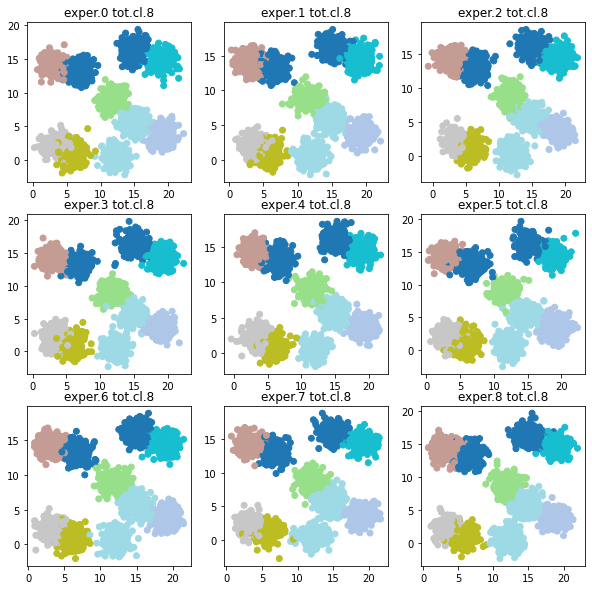

In [ ]:
fig,axs=pp.subplots(max_experiments//3,3,figsize=(10,10))
for i in range(max_experiments):
  x=XARRval[XARRval[:,N_FEATURES]==i]
  y=np.argmax(base_model.predict(x[:,:N_FEATURES]),axis=1)
  yt=np.argmax(YARRval[XARRval[:,N_FEATURES]==i],axis=1)
  axs[i//3,i%3].scatter(x[:,0],x[:,1],c=y,cmap='tab20');
  axs[i//3,i%3].set_title('exper.'+str(i)+' tot.cl.'+str(len(set(list(y)))))

### Сравнение внешних классов и внтуренних для эксперимента №9 

In [ ]:

con_mat = tf.math.confusion_matrix(labels=yt,predictions=y).numpy()
print(con_mat)

[[  0   0 190   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 202 238   0   0]
 [  0 423   0   0   0   0   0   0   0   0   0   0 215   0]
 [  0   0   0   0   0   0   0   0 257   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 228]
 [  0   0   0   0 228   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 240]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


# Effect: divided into 7 in each experiment (with actual 10 classes) - detected 8 hidden classes.

# In case of mistakes of clusterer - greater number of detected clusters

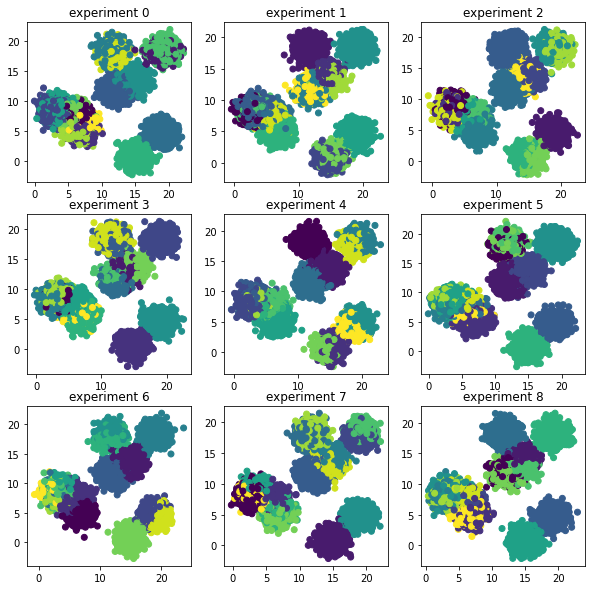

In [ ]:
from sklearn.mixture import GaussianMixture
gm=GaussianMixture(n_components=N_CLASSES*15//10)
cl=[]
XOUT=[]
for i in range(max_experiments):
  cl.append(gm.fit_predict(x_exp[i]))

fig,axs=pp.subplots(max_experiments//3,3,figsize=(10,10))
for i in range(max_experiments):
  axs[i//3,i%3].set_title('experiment '+str(i))
  axs[i//3,i%3].scatter(x_exp[i][:,0],x_exp[i][:,2],c=cl[i])

## Lots of code

### Configure network

In [ ]:
for i in range(max_experiments):
  p=np.array([[x] for x in cl[i]])
  print('experiment shape:',p.shape)
  if i==0:
    clusters=p
    XOUT=np.array(x_exp[i])[:,:N_FEATURES]
  else:
    clusters=np.concatenate((clusters,p))
    XOUT=np.concatenate((XOUT,np.array(x_exp[i])[:,:N_FEATURES]))
idx_exp=np.array(idx_exp)
print('idx_exp:',idx_exp.shape)
print('clusters shape:',clusters.shape)
input_data=np.concatenate((XOUT,idx_exp,clusters),axis=1)
print('data shape:',input_data.shape)

experiment shape: (11064, 1)
experiment shape: (11043, 1)
experiment shape: (10991, 1)
experiment shape: (11135, 1)
experiment shape: (11146, 1)
experiment shape: (11166, 1)
experiment shape: (11236, 1)
experiment shape: (11083, 1)
experiment shape: (11136, 1)
idx_exp: (100000, 1)
clusters shape: (100000, 1)
data shape: (100000, 10)


In [ ]:
vecInputNum=N_FEATURES
MaxDates=max_experiments

output_class_M=clusters[:,0].max()+1
max_days=idxs[:,0].max()+1

ASYMMETRY=dict()
for i in range(output_class_M):
  ASYMMETRY[i]=clusters[clusters[:,0]==i].shape[0]
print('Asymmetry:',ASYMMETRY)

Asymmetry: {0: 7033, 1: 8248, 2: 7207, 3: 7212, 4: 8929, 5: 6650, 6: 6660, 7: 8205, 8: 8186, 9: 7217, 10: 4868, 11: 5264, 12: 4905, 13: 5053, 14: 4363}


In [ ]:
print('input data shape',input_data.shape)
XARR1=input_data[:,:N_FEATURES+1]
print('Input data for network:',XARR1.shape)
YARR1=tf.keras.utils.to_categorical(input_data[:,N_FEATURES+1],num_classes=output_class_M)
print('Categorical cluster nums:',YARR1.shape)

input data shape (100000, 10)
Input data for network: (100000, 9)
Categorical cluster nums: (100000, 15)


In [ ]:
vecInputNumPoly=vecInputNum
hidden_dim=vecInputNumPoly+output_class_M+2  #universal approximation theorem
if hidden_dim < vecInputNumPoly*2+1:
 hidden_dim = vecInputNumPoly*2+1  #Kolmogorov theorem
print('yarr shape',np.array(YARR1).shape);
print('xarr shape',np.array(XARR1).shape);

yarr shape (100000, 15)
xarr shape (100000, 9)


### Separate dataset into train and test datasets

In [ ]:
from sklearn.model_selection import train_test_split
XARRtrain,XARRval,YARRtrain,YARRval=train_test_split(XARR1,YARR1,test_size=0.2)

XARRtrain=np.array(XARRtrain)
YARRtrain=np.array(YARRtrain)
XARRval=np.array(XARRval)
YARRval=np.array(YARRval)

print('Xt:',XARRtrain.shape)
print('Yt:',YARRtrain.shape)
print('Xtst:',XARRval.shape)
print('Ytst:',YARRval.shape)


# print(XARRtrain)

#XARRval=np.array(random.sample(XARR1,int(num*0.1)))
#YARRval=np.array(YARR1[int(num*0.5):])


#YARRval=np.array(random.sample(YARR1,int(num*0.1)))

#f.close()
# print(XARR1[0],YARR1[0])
print("X train shape:",XARRtrain.shape)
print("Y train shape:",YARRtrain.shape)

# from sklearn.utils import class_weight
# print(np.unique(np.array(Cl_Y)))
# class_weight = class_weight.compute_class_weight('balanced',np.unique(np.array(Cl_Y)),Cl_Y)
# print("sklearn class weights ",class_weight)

print ("final calc weights")

# print(class_weight)
# min_cw=class_weight.min()
# sum_cw=class_weight.sum()

Xt: (80000, 9)
Yt: (80000, 15)
Xtst: (20000, 9)
Ytst: (20000, 15)
X train shape: (80000, 9)
Y train shape: (80000, 15)
final calc weights


### Calculate weights

In [ ]:
gam=1
class_weight_dict=dict()
for i in range(output_class_M):
  class_weight_dict[i]=0
sum_p=0
for key, value in ASYMMETRY.items() :
  p=ASYMMETRY[key]
  sum_p+=p
total_nonzero_classes=0
SMALLEST_CLASS=1e-3
#REG_LAMBDA=SMALLEST_CLASS*0.1
REG_LAMBDA=SMALLEST_CLASS

for key, value in ASYMMETRY.items() :
  p=(ASYMMETRY[key])/sum_p
#  if(classes_sel[key] in class_weight_dict):
  class_weight_dict[key]=0  
  if(p>SMALLEST_CLASS):
    class_weight_dict[key]=1/p**gam  
    total_nonzero_classes+=1

totalClassNum=output_class_M*2 #total_nonzero_classes

print("final weights",class_weight_dict)
print("total hidden classes",totalClassNum)
#quit()

final weights {0: 14.218683349921797, 1: 12.124151309408342, 2: 13.875398917718885, 3: 13.865779256794232, 4: 11.199462425803562, 5: 15.037593984962406, 6: 15.015015015015013, 7: 12.187690432663011, 8: 12.21597849987784, 9: 13.856172925038106, 10: 20.542317173377157, 11: 18.996960486322187, 12: 20.38735983690112, 13: 19.790223629527013, 14: 22.920009168003666}
total hidden classes 30


### Build network

### Build Classifier network

In [ ]:
vecInputNum2=vecInputNumPoly

print ("configure model short with ",vecInputNum2," paramters")
vectorInput = keras.Input(shape=(vecInputNum2,), name="vec_input")  
vec_features= vectorInput

basic_act='selu'
lang_act='softmax'
for layer in range(2):
  vec_features = layers.Dense(hidden_dim, name="transform1_"+str(layer), activation=basic_act)(vec_features)
  vec_features = layers.Dense(hidden_dim, name="transform2_"+str(layer), activation=basic_act)(vec_features)
  vec_features = layers.Dense(hidden_dim, name="transform3_"+str(layer), activation=basic_act)(vec_features)
  vec_features=tf.keras.layers.BatchNormalization()(vec_features)
  vec_features = layers.Dropout(0.3)(vec_features)


secondaryClasses = layers.Dense(totalClassNum, 
				name="secondaryClasses", 
				activation=lang_act,
				)(vec_features)

base_model = keras.Model(
    inputs=[vectorInput],
    outputs=[secondaryClasses],
    trainable=True
)

base_model.summary()

configure model short with  8  paramters
Model: "model_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vec_input (InputLayer)      [(None, 8)]               0         
                                                                 
 transform1_0 (Dense)        (None, 25)                225       
                                                                 
 transform2_0 (Dense)        (None, 25)                650       
                                                                 
 transform3_0 (Dense)        (None, 25)                650       
                                                                 
 batch_normalization_65 (Bat  (None, 25)               100       
 chNormalization)                                                
                                                                 
 dropout_65 (Dropout)        (None, 25)                0         
                 

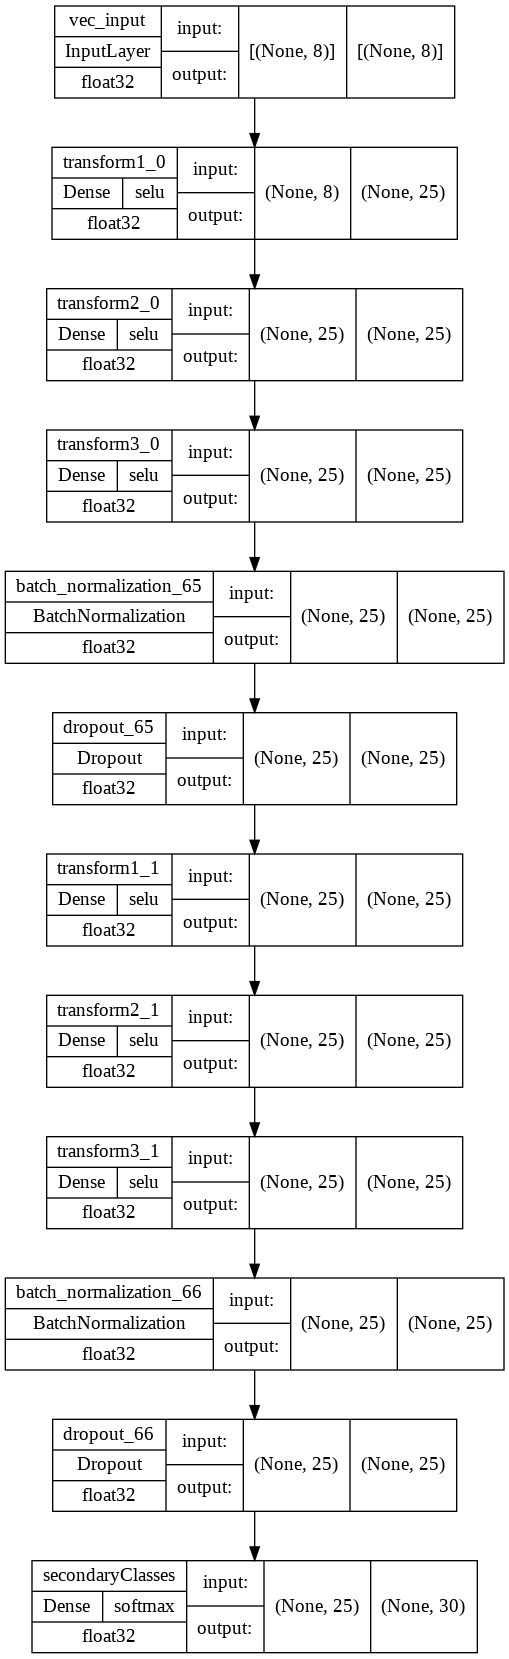

In [ ]:
keras.utils.plot_model(base_model, 'model.classifier.png', show_shapes=True,show_layer_activations=True, show_layer_names=True,show_dtype=True)

### Build Wrap network

In [ ]:
print ("configure model")
totalInput = keras.Input(shape=(vecInputNumPoly+1,), name="vec_date")  

#split input into experiment numer and classifier input
vec_input,date_input2=tf.split(totalInput, [vecInputNum2,1], 1)

# pass through Classifier model
secondaryClassesOut=base_model(vec_input)

#build rectangle embedding for each experiment
date_input=date_input2
sec_input_features=secondaryClassesOut
MaxExperiments=max_experiments
#from tensorflow.keras.constraints import NonNeg

from tensorflow.keras.constraints import NonNeg,non_neg

embedding_layer=layers.Embedding(MaxExperiments,totalClassNum*output_class_M,name="ExperimentEmb",
		    # embeddings_constraint=NonNeg,
        # embeddings_initializer='ones',
		    )
print('DI shape',date_input.shape)
conversion_weights=embedding_layer(date_input)
print('CW',conversion_weights.shape)

#transform embedding row into rectangle matrix
conversion_matrix_T=layers.Reshape((output_class_M,totalClassNum))(conversion_weights)
#make sure that matrix is non-negative valued
conversion_matrix_T=layers.ReLU(name="getOnlyPositiveValues")(conversion_matrix_T)

print('CM shape',conversion_matrix_T.shape)
print('SIF shape',sec_input_features.shape)

#transform classes of classifier into classes of GaussianMixture for each experiment separately
output_features=layers.Dot(axes=(2,1))([conversion_matrix_T,sec_input_features])
print('OF3hape',output_features.shape)

#pass through simple classifer

#actualOutputClasses = layers.Softmax()(output_features)


actualOutputClasses = layers.Dense(output_class_M, 
                                   name="actualOutputClasses", 
                                   activation='softmax',
                                   kernel_constraint=non_neg(),
        )(output_features)

model = keras.Model(
    inputs=[totalInput],
    outputs=[actualOutputClasses],
)
model.summary()

configure model
DI shape (None, 1)
CW (None, 1, 450)
CM shape (None, 15, 30)
SIF shape (None, 30)
OF3hape (None, 15)
Model: "model_58"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vec_date (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 tf.split_30 (TFOpLambda)       [(None, 8),          0           ['vec_date[0][0]']               
                                 (None, 1)]                                                       
                                                                                                  
 ExperimentEmb (Embedding)      (None, 1, 450)       4050        ['tf.split_30[0][1]']            
                                                                         

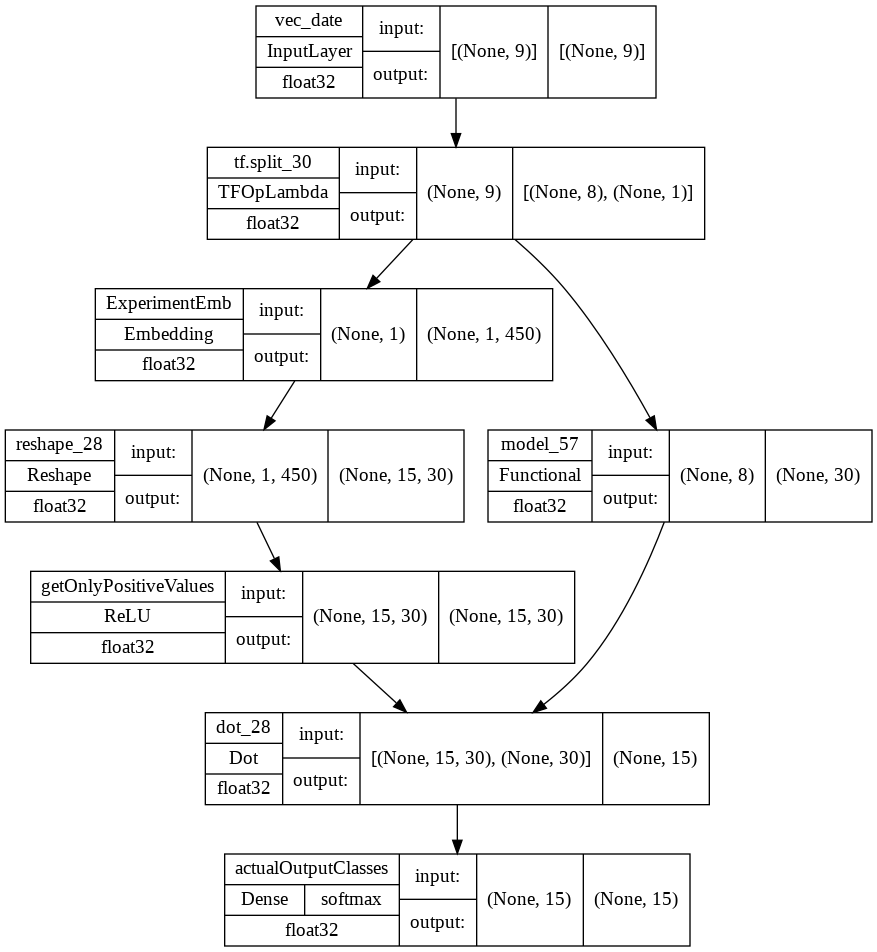

In [ ]:
keras.utils.plot_model(model, 'model.wrap.png', show_shapes=True,show_layer_activations=True, show_layer_names=True,show_dtype=True)

### Compile and plot models

In [ ]:
print ("compile model")
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.AUC(curve='PR'),
                       tf.keras.metrics.AUC(curve='ROC')
                      ]
              )


compile model


### Fit models

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc_51', mode='max', patience=5)
print ("fit model...")
model.fit(x=XARRtrain,y=YARRtrain,batch_size=32,
          epochs=1500,verbose=1,validation_split=0.2,
          class_weight = class_weight_dict, 
          callbacks=[callback])
print ("save model")

tf.keras.models.save_model(model, 'model.wrap.ec')
tf.keras.models.save_model(base_model, 'model.classifier.ec')
# !tar -cvzf dbscan-model-Full-p_le_e-4-vars_15-sm-100epoches.tgz ./dbscan


fit model...
Epoch 1/1500
2000/2000 [==============================] - 13s 6ms/step - loss: 18.8130 - auc_51: 0.6206 - auc_52: 0.9510 - val_loss: 1.1573 - val_auc_51: 0.6352 - val_auc_52: 0.9551
Epoch 2/1500
2000/2000 [==============================] - 8s 4ms/step - loss: 17.0225 - auc_51: 0.6417 - auc_52: 0.9584 - val_loss: 1.0731 - val_auc_51: 0.6478 - val_auc_52: 0.9608
Epoch 3/1500
2000/2000 [==============================] - 7s 4ms/step - loss: 16.0149 - auc_51: 0.6519 - auc_52: 0.9626 - val_loss: 1.0214 - val_auc_51: 0.6537 - val_auc_52: 0.9637
Epoch 4/1500
2000/2000 [==============================] - 7s 4ms/step - loss: 15.3174 - auc_51: 0.6591 - auc_52: 0.9648 - val_loss: 0.9839 - val_auc_51: 0.6597 - val_auc_52: 0.9654
Epoch 5/1500
2000/2000 [==============================] - 7s 4ms/step - loss: 14.8769 - auc_51: 0.6625 - auc_52: 0.9659 - val_loss: 0.9582 - val_auc_51: 0.6617 - val_auc_52: 0.9663
Epoch 6/1500
2000/2000 [==============================] - 8s 4ms/step - loss: 14.

### Estimate fit quality at train dataset

In [ ]:
print ("get error matrix")
y_pred=model.predict(XARRtrain)
yp=tf.math.argmax(y_pred,axis=1)
yt=tf.math.argmax(YARRtrain,axis=1)
con_mat = tf.math.confusion_matrix(labels=yt,predictions=yp).numpy()
con_mat_norm = np.around(con_mat.astype('float') / (con_mat.sum(axis=1)[:, np.newaxis]+1), decimals=2)
np.set_printoptions(precision=4)
print('train set diag',np.diag(con_mat_norm))

get error matrix
train set diag [0.62 0.52 0.63 0.47 0.75 0.66 0.49 0.68 0.81 0.38 0.52 0.42 0.58 0.35
 0.57]


### Estimate fit quality at test dataset

In [ ]:


y_pred=model.predict(XARRval)
yp=tf.math.argmax(y_pred,axis=1)
yt=tf.math.argmax(YARRval,axis=1)
con_mat = tf.math.confusion_matrix(labels=yt,predictions=yp).numpy()
con_mat_norm = np.around(con_mat.astype('float') / (con_mat.sum(axis=1)[:, np.newaxis]+1), decimals=2)
print('val  set diag',np.diag(con_mat_norm))

print ("error matrix:")

print(con_mat_norm)

val  set diag [0.63 0.54 0.62 0.46 0.76 0.7  0.5  0.69 0.83 0.38 0.55 0.45 0.58 0.34
 0.54]
error matrix:
[[0.63 0.   0.   0.   0.   0.   0.   0.   0.16 0.   0.14 0.07 0.   0.
  0.  ]
 [0.   0.54 0.   0.08 0.   0.   0.13 0.17 0.   0.08 0.   0.   0.   0.
  0.  ]
 [0.   0.   0.62 0.   0.   0.   0.   0.07 0.   0.   0.   0.   0.   0.08
  0.23]
 [0.   0.   0.   0.46 0.   0.   0.   0.21 0.1  0.   0.08 0.07 0.08 0.
  0.  ]
 [0.   0.   0.   0.   0.76 0.   0.   0.   0.11 0.   0.07 0.   0.   0.05
  0.  ]
 [0.   0.   0.   0.   0.07 0.7  0.   0.   0.05 0.   0.08 0.   0.1  0.
  0.  ]
 [0.   0.08 0.   0.   0.   0.   0.5  0.   0.   0.   0.09 0.   0.16 0.08
  0.09]
 [0.   0.   0.13 0.   0.   0.   0.   0.69 0.   0.06 0.   0.   0.06 0.
  0.06]
 [0.06 0.   0.12 0.   0.   0.   0.   0.   0.83 0.   0.   0.   0.   0.
  0.  ]
 [0.   0.07 0.   0.   0.17 0.14 0.   0.   0.   0.38 0.07 0.07 0.   0.
  0.1 ]
 [0.1  0.   0.11 0.   0.   0.   0.   0.13 0.   0.11 0.55 0.   0.   0.
  0.  ]
 [0.   0.12 0.   0.1  0.   0. 

## Illustration of classifier

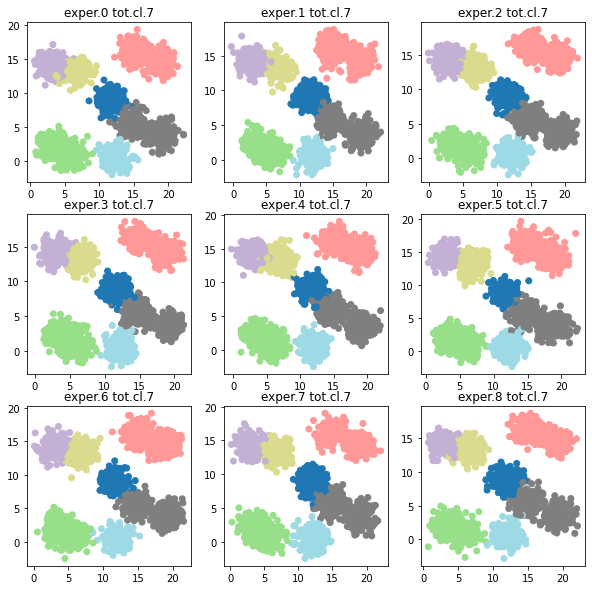

In [ ]:
fig,axs=pp.subplots(max_experiments//3,3,figsize=(10,10))
for i in range(max_experiments):
  x=XARRval[XARRval[:,N_FEATURES]==i]
  y=np.argmax(base_model.predict(x[:,:N_FEATURES]),axis=1)
  yt=np.argmax(YARRval[XARRval[:,N_FEATURES]==i],axis=1)
  axs[i//3,i%3].scatter(x[:,0],x[:,1],c=y,cmap='tab20');
  axs[i//3,i%3].set_title('exper.'+str(i)+' tot.cl.'+str(len(set(list(y)))))

### Сравнение внешних классов и внтуренних для эксперимента №9 

In [ ]:

con_mat = tf.math.confusion_matrix(labels=yt,predictions=y).numpy()

print(con_mat.sum(axis=0))

[  0 234   0   0   0   0   0   0 426   0   0   0 425   0 212   0   0   0
   0   0   0 477   0   0   0 220   0   0   0 233]


# Effect: divided into 15 in each experiment (with actual 10 classes) - detected only 7 hidden classes. 

# CONCLUSION: the hidden classes have less detection errors than clusterization of single experiment.

# Application to actual radar data

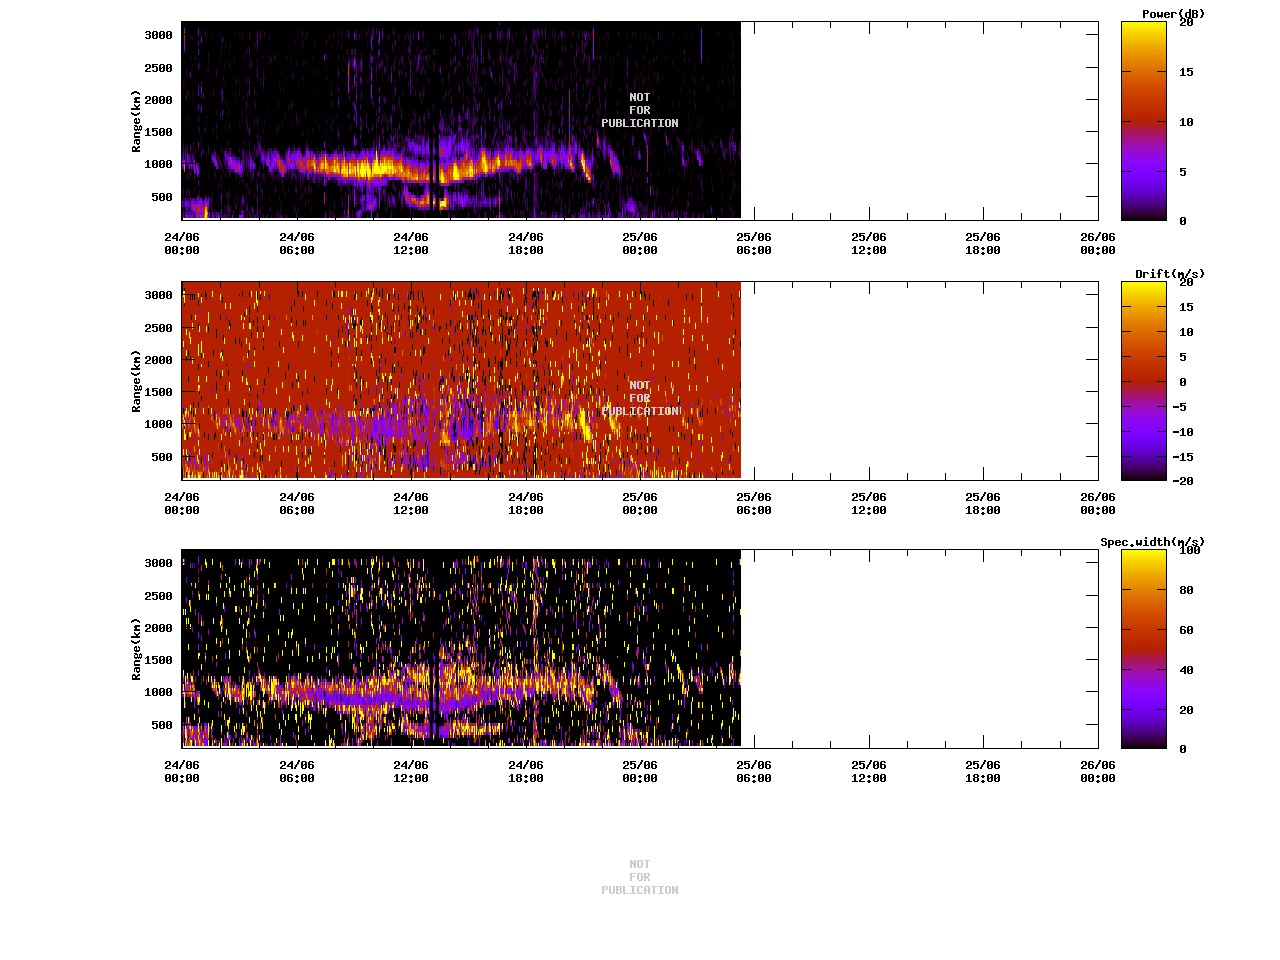

## Modifications for radar data

1. Clusterer uses more features than classifier

2. Before classifier the features are increased by PolynomialFeatures(2) transformation

3. Trained network applied to realtime data using C-API at C language, not in Python

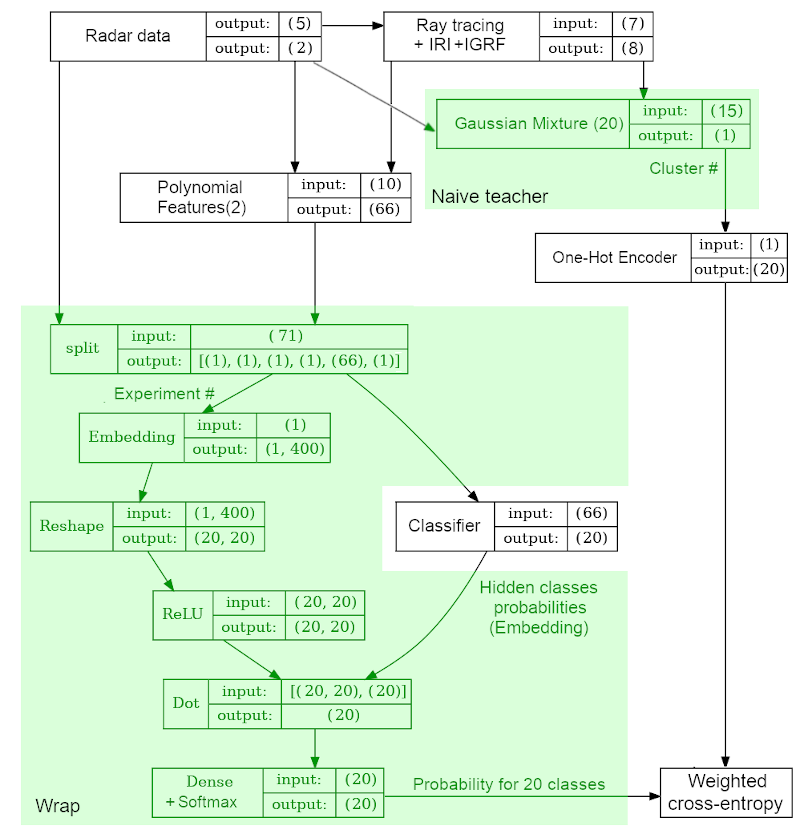

## Realtime data http://sdrus.iszf.irk.ru/node/94

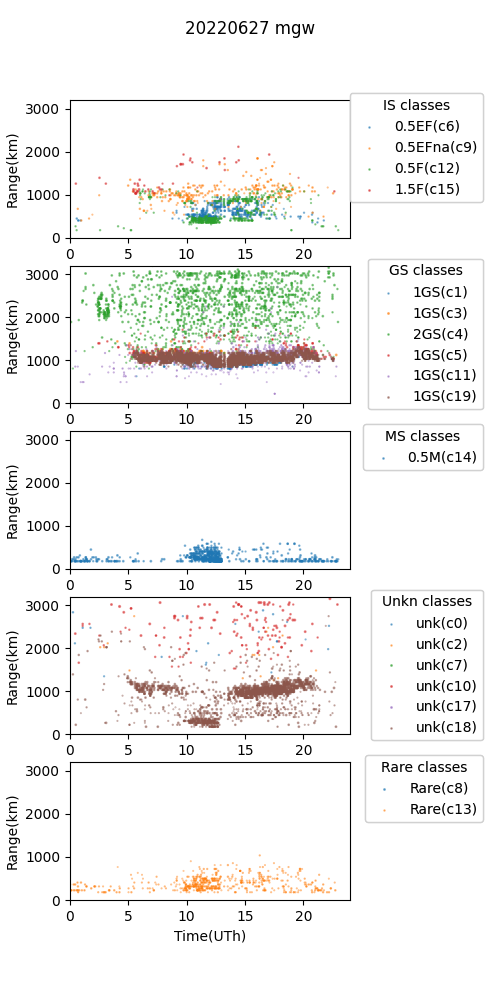

# Details in https://arxiv.org/abs/2201.05735